## Module installation

In [4]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 11.1/11.1 MB 28.5 MB/s eta 0:00:00
     --------------------------------------- 41.2/41.2 MB 24.2 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 150.0/150.0 MB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
%pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
%pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 238.4/238.4 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [13]:
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [15]:
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [16]:
%matplotlib inline

## Load Datasets

In [20]:
train_df = pd.read_csv(r"C:\Users\Ranesh RK\Downloads\fraud_detection\datasets\train_df.csv")
test_df = pd.read_csv(r"C:\Users\Ranesh RK\Downloads\fraud_detection\datasets\test_df.csv")

In [23]:
col_names = train_df.columns.to_list()
print(col_names)

['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'trans_date_time', 'hour', 'day', 'month', 'dayofweek', 'distance_km', 'age', 'is_weekend', 'time_period', 'transaction_recency', 'merchant_fraud_rate', 'merchant_transaction_count', 'category_fraud_rate', 'category_transaction_count', 'customer_avg_amount', 'amount_ratio']


In [24]:
train_df.drop(columns="Unnamed: 0", inplace=True)
test_df.drop(columns="Unnamed: 0", inplace=True)

In [25]:
col_names = train_df.columns.to_list()
print(col_names)

['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'trans_date_time', 'hour', 'day', 'month', 'dayofweek', 'distance_km', 'age', 'is_weekend', 'time_period', 'transaction_recency', 'merchant_fraud_rate', 'merchant_transaction_count', 'category_fraud_rate', 'category_transaction_count', 'customer_avg_amount', 'amount_ratio']


## Feature selection

In [26]:
# Select features for model training
categorical_features = ['gender', 'time_period', 'category']
numerical_features = [
    'amt', 'distance_km', 'age', 'hour', 'day', 'month', 'dayofweek',
    'city_pop', 'merchant_fraud_rate', 'merchant_transaction_count',
    'category_fraud_rate', 'category_transaction_count', 'amount_ratio',
    'transaction_recency'
]

In [27]:
# Define X and y for training
X = train_df[categorical_features + numerical_features]
y = train_df['is_fraud']

X_test = test_df[categorical_features + numerical_features]
y_test = test_df['is_fraud'] if 'is_fraud' in test_df.columns else None

## Check Feature Importance

In [28]:
# Check feature importance with a simple model before full pipeline
print("\nChecking initial feature importance...")
rf_check = RandomForestClassifier(n_estimators=100, random_state=42)
rf_check.fit(pd.get_dummies(X, drop_first=True), y)


Checking initial feature importance...


RandomForestClassifier(random_state=42)

In [29]:
feature_importances = pd.DataFrame({
    'feature': pd.get_dummies(X, drop_first=True).columns,
    'importance': rf_check.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances.head(15))

                       feature  importance
0                          amt    0.274222
12                amount_ratio    0.199879
2                          age    0.087417
3                         hour    0.066725
11  category_transaction_count    0.048049
9   merchant_transaction_count    0.039265
10         category_fraud_rate    0.033941
7                     city_pop    0.031224
8          merchant_fraud_rate    0.029901
13         transaction_recency    0.026808
21        category_grocery_pos    0.025524
1                  distance_km    0.024425
15         time_period_evening    0.018179
4                          day    0.017552
14                    gender_M    0.013468


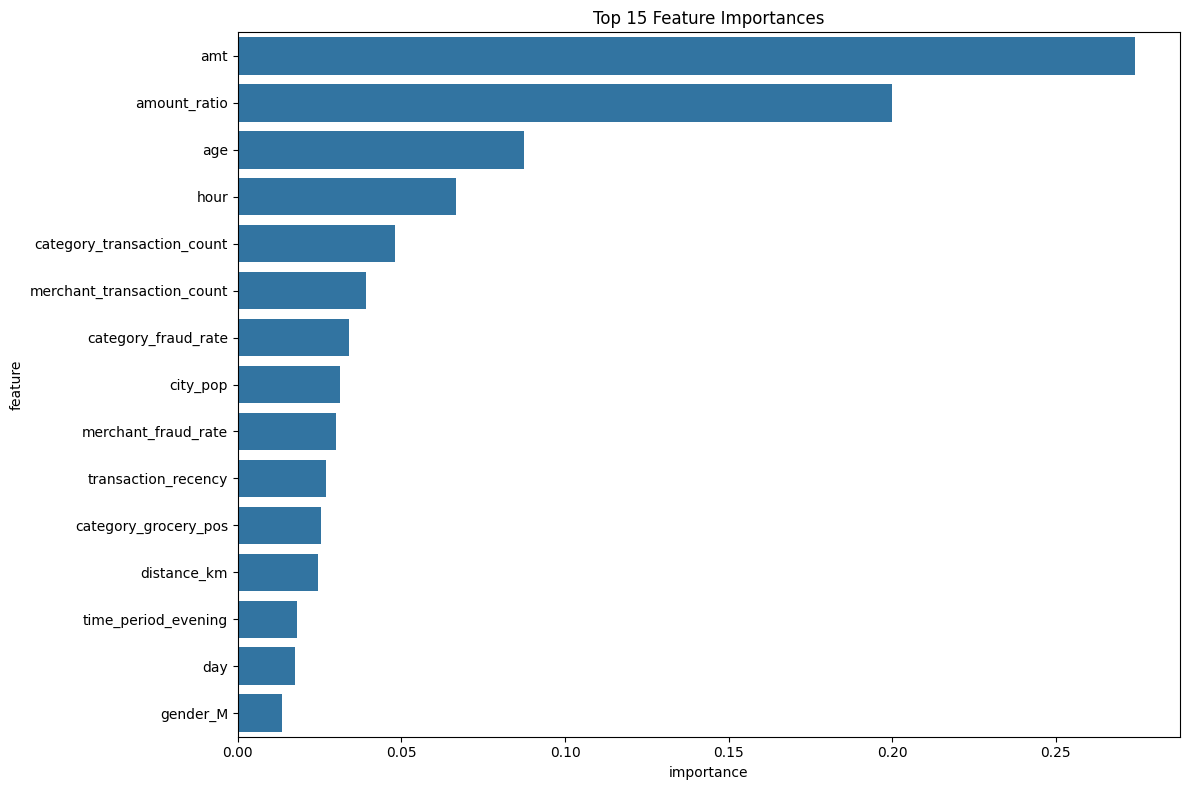

In [30]:
# Top 15 feature importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

## Preprocessing Pipeline

In [31]:
# Create preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Model training

In [32]:
# Define different models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

In [33]:
# Create a function to display model performance
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    print(f"\n{model_name} Performance:")
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    return y_prob, roc_auc, pr_auc

In [34]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)


Handling class imbalance with SMOTE...



Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.89      0.83      0.86      1501

    accuracy                           1.00    259335
   macro avg       0.95      0.92      0.93    259335
weighted avg       1.00      1.00      1.00    259335



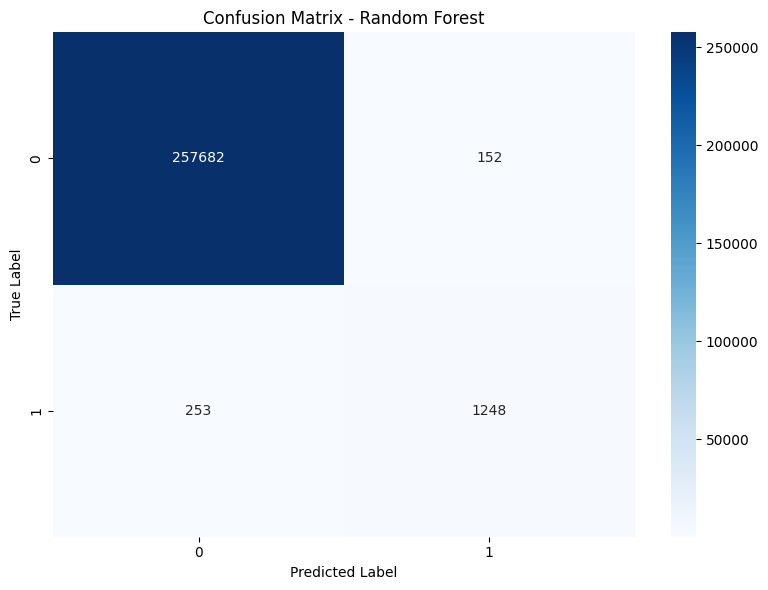

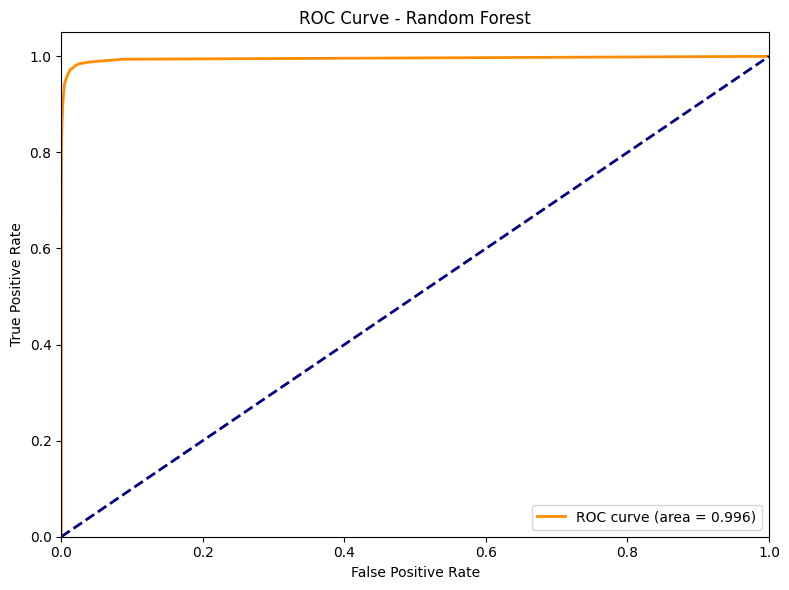

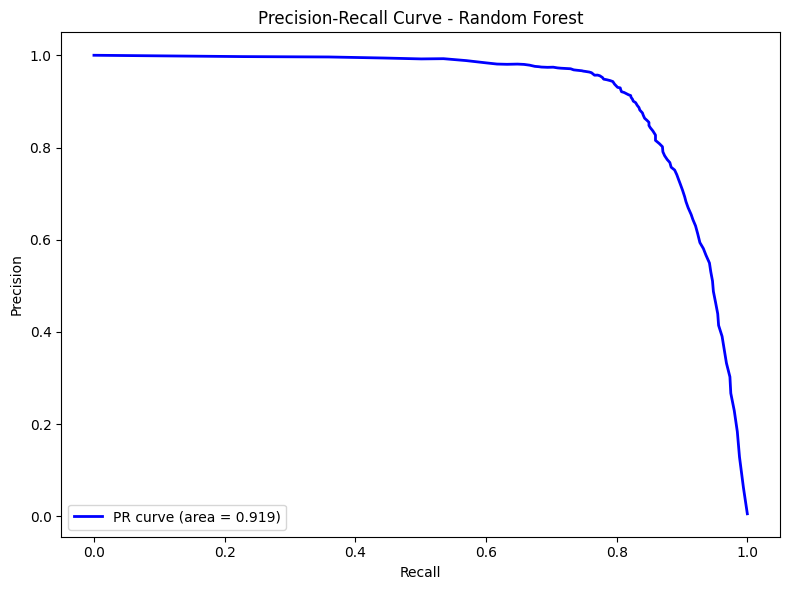


Training Gradient Boosting...

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.22      0.92      0.36      1501

    accuracy                           0.98    259335
   macro avg       0.61      0.95      0.67    259335
weighted avg       1.00      0.98      0.99    259335



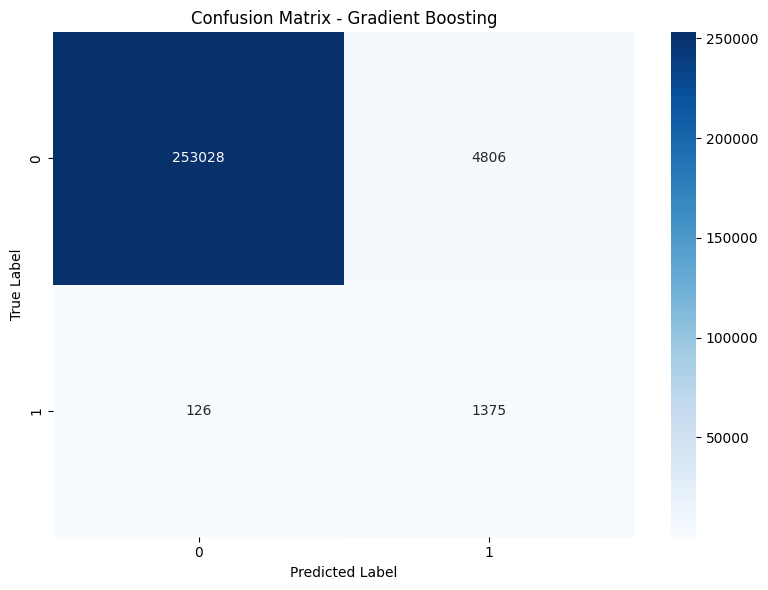

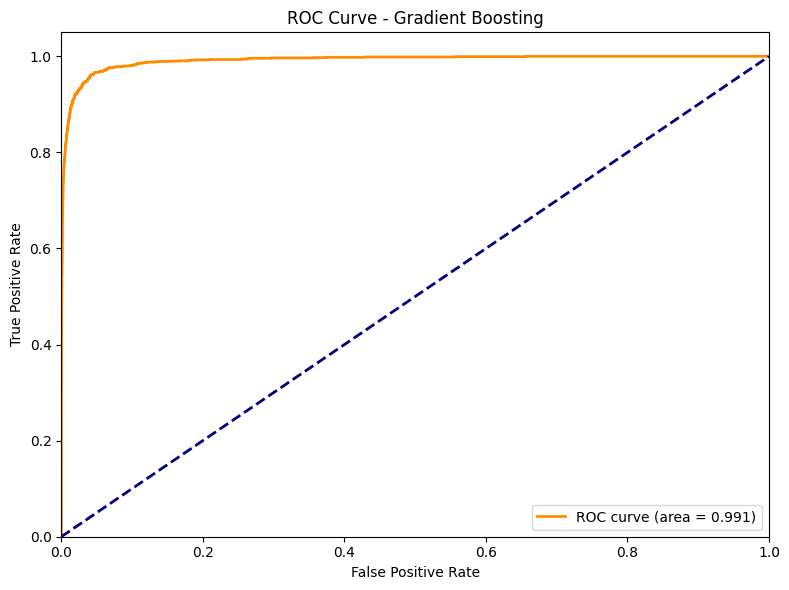

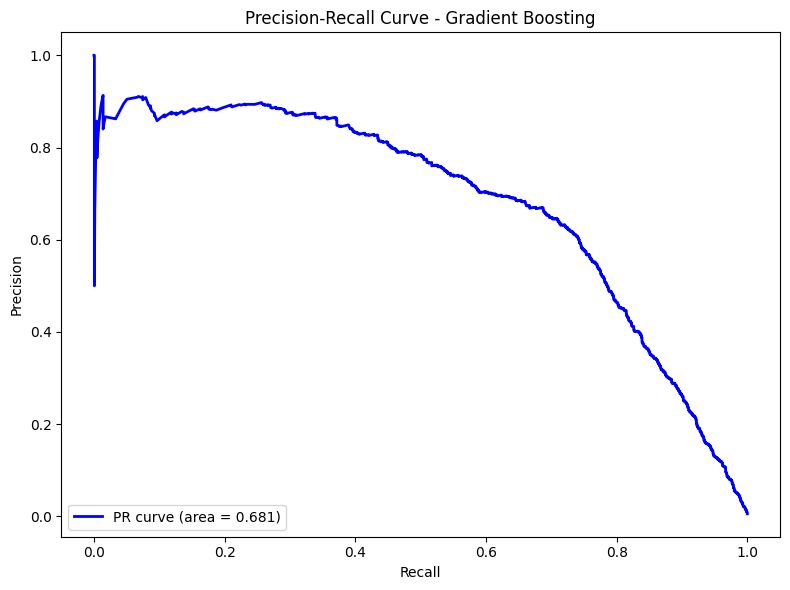


Training XGBoost...


C:\Users\Ranesh RK\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:37:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.86      0.88      0.87      1501

    accuracy                           1.00    259335
   macro avg       0.93      0.94      0.93    259335
weighted avg       1.00      1.00      1.00    259335



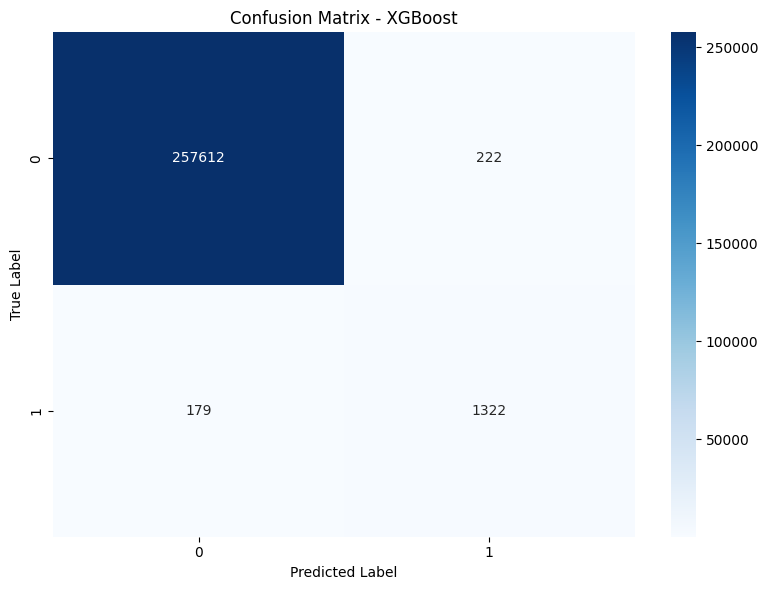

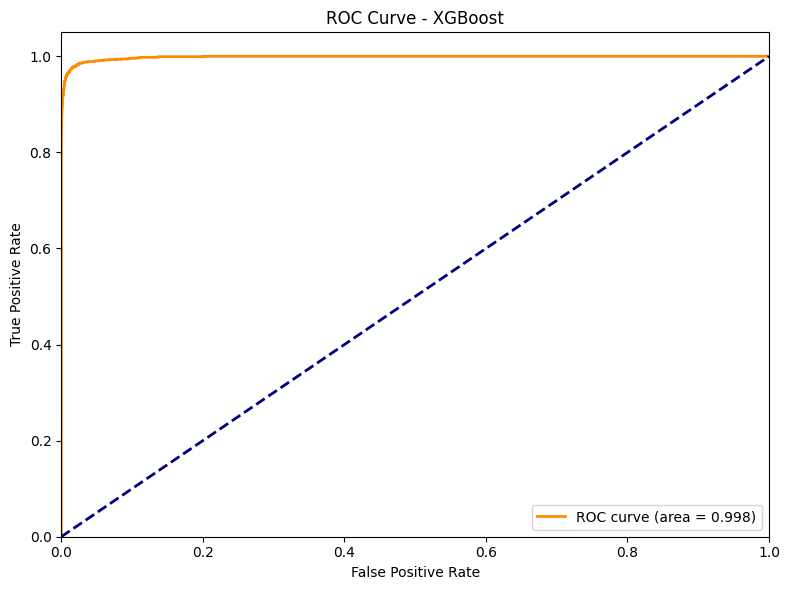

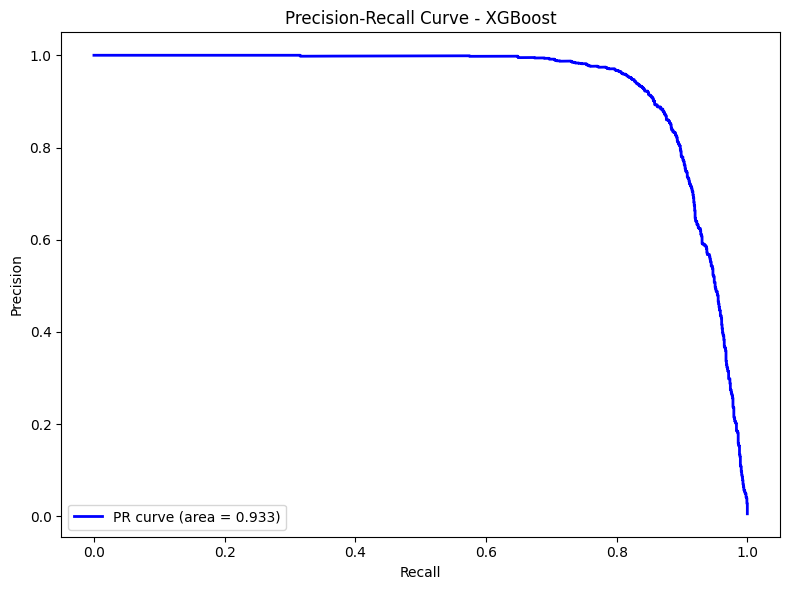


Training LightGBM...
[LightGBM] [Info] Number of positive: 1031335, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7176
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\Ranesh RK\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ranesh RK\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.69      0.88      0.77      1501

    accuracy                           1.00    259335
   macro avg       0.84      0.94      0.88    259335
weighted avg       1.00      1.00      1.00    259335



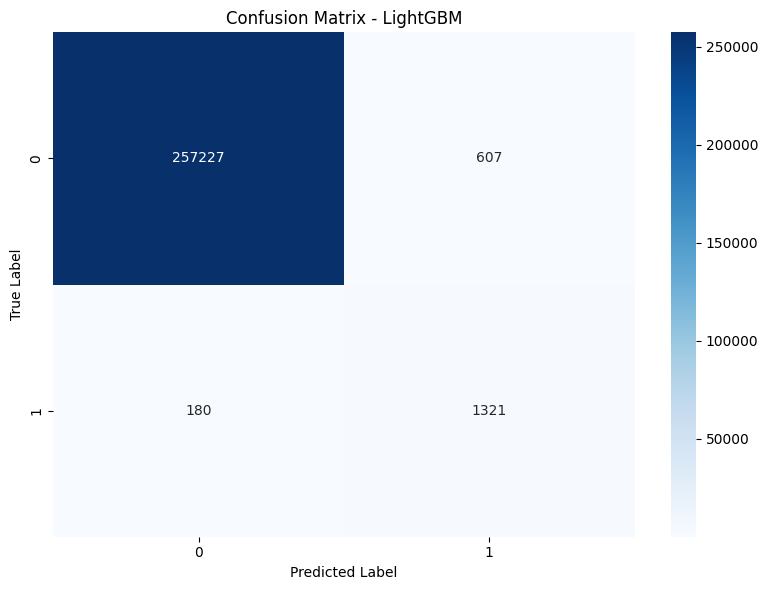

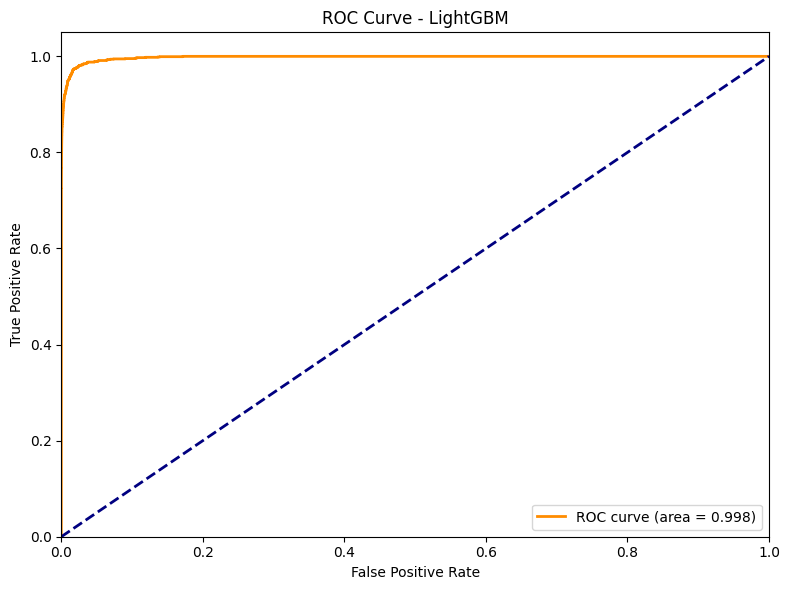

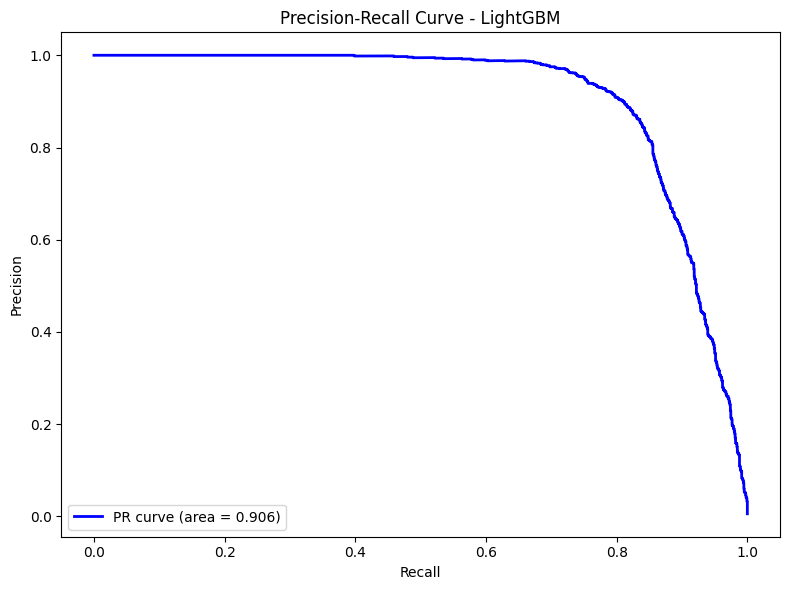

In [35]:
# Dictionary to store model results
model_results = {}

# Train and evaluate models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Create a pipeline with preprocessing, SMOTE, and the model
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model
    y_prob, roc_auc, pr_auc = evaluate_model(pipeline, X_val, y_val, model_name)
    
    # Store results
    model_results[model_name] = {
        'pipeline': pipeline,
        'y_prob': y_prob,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

## Model Performance

In [36]:
# Compare model performances
model_comparison = pd.DataFrame({
    'Model': list(model_results.keys()),
    'ROC AUC': [results['roc_auc'] for results in model_results.values()],
    'PR AUC': [results['pr_auc'] for results in model_results.values()]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('PR AUC', ascending=False))


Model Comparison:
               Model   ROC AUC    PR AUC
2            XGBoost  0.998219  0.933336
0      Random Forest  0.995517  0.918825
3           LightGBM  0.997761  0.905950
1  Gradient Boosting  0.991351  0.681038


In [37]:
# Select best model based on PR AUC (more relevant for imbalanced data)
best_model_name = model_comparison.sort_values('PR AUC', ascending=False).iloc[0]['Model']
best_model = model_results[best_model_name]['pipeline']

print(f"\nBest model: {best_model_name}")

# Train the best model on the entire training data
best_model.fit(X, y)


Best model: XGBoost


C:\Users\Ranesh RK\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:37:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'distance_km', 'age',
                                                   'hour', 'day', 'month',
                                                   'dayofweek', 'city_pop',
                                                   'merchant_fraud_rate',
                                                   'merchant_transaction_count',
                                                   'category_fraud_rate',
                                                   'category_transaction_count',
                                                   'amount_ratio',
                                                   'transaction_recency']),
                                                 ('cat',
                                                  Pipeline(steps...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])


Evaluating best model on test set...

XGBoost (Test Set) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.75      0.83      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.92      0.89    555719
weighted avg       1.00      1.00      1.00    555719



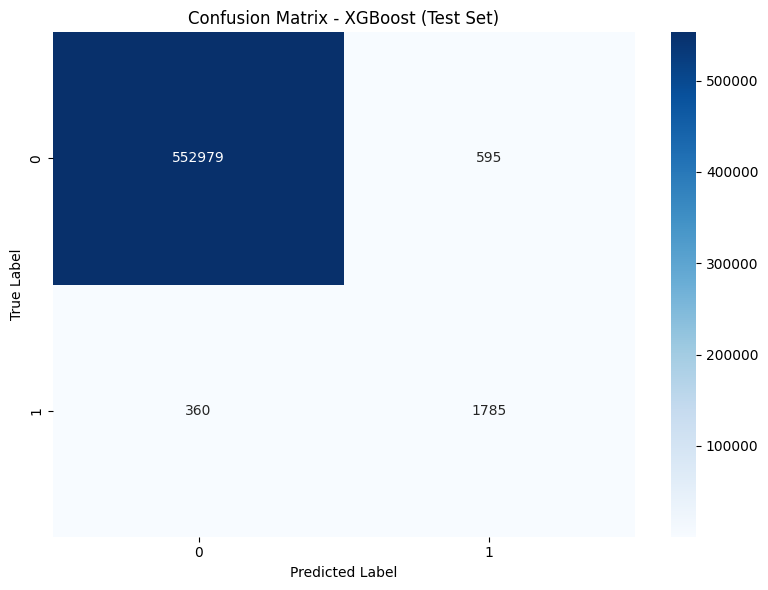

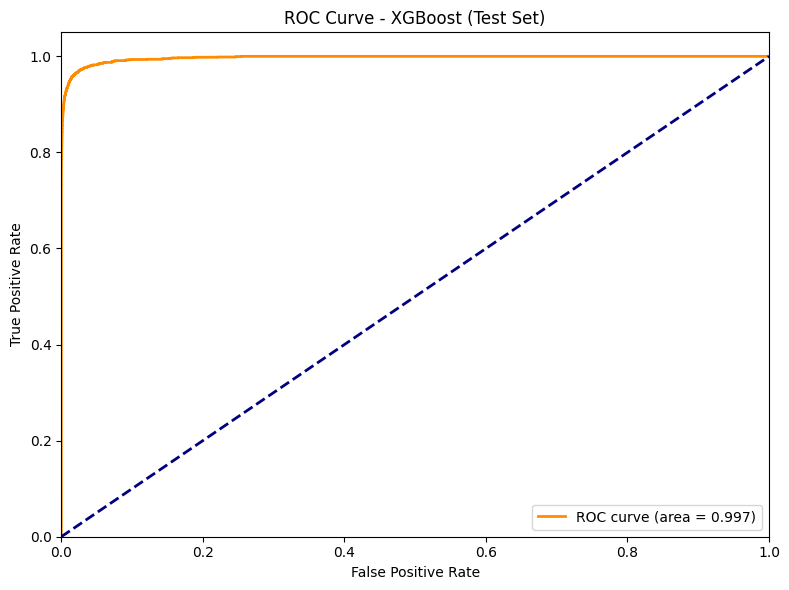

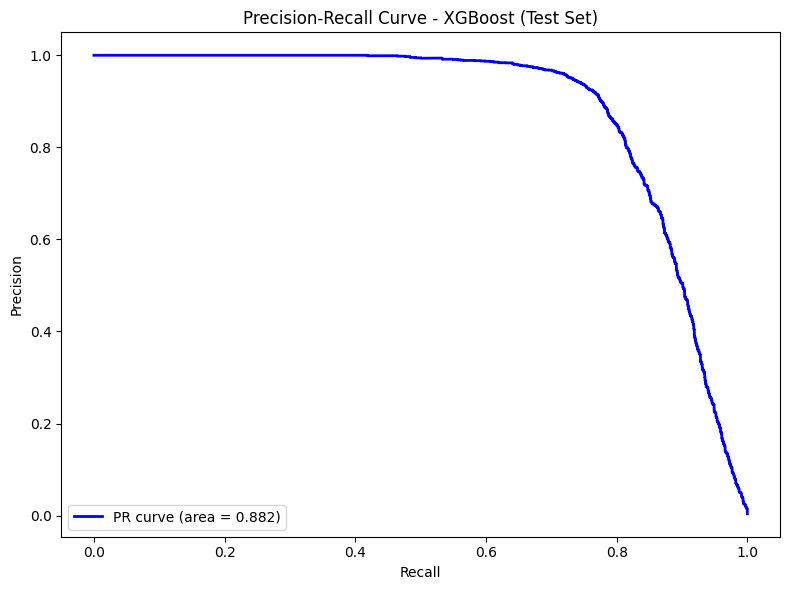

(array([1.5181755e-06, 1.3538342e-03, 3.8922651e-04, ..., 8.1000320e-04,
        2.7462393e-02, 1.3847798e-04], shape=(555719,), dtype=float32),
 np.float64(0.9967330499600802),
 np.float64(0.8822888778298343))

In [38]:
print("\nEvaluating best model on test set...")
evaluate_model(best_model, X_test, y_test, f"{best_model_name} (Test Set)")

## Feature Importance

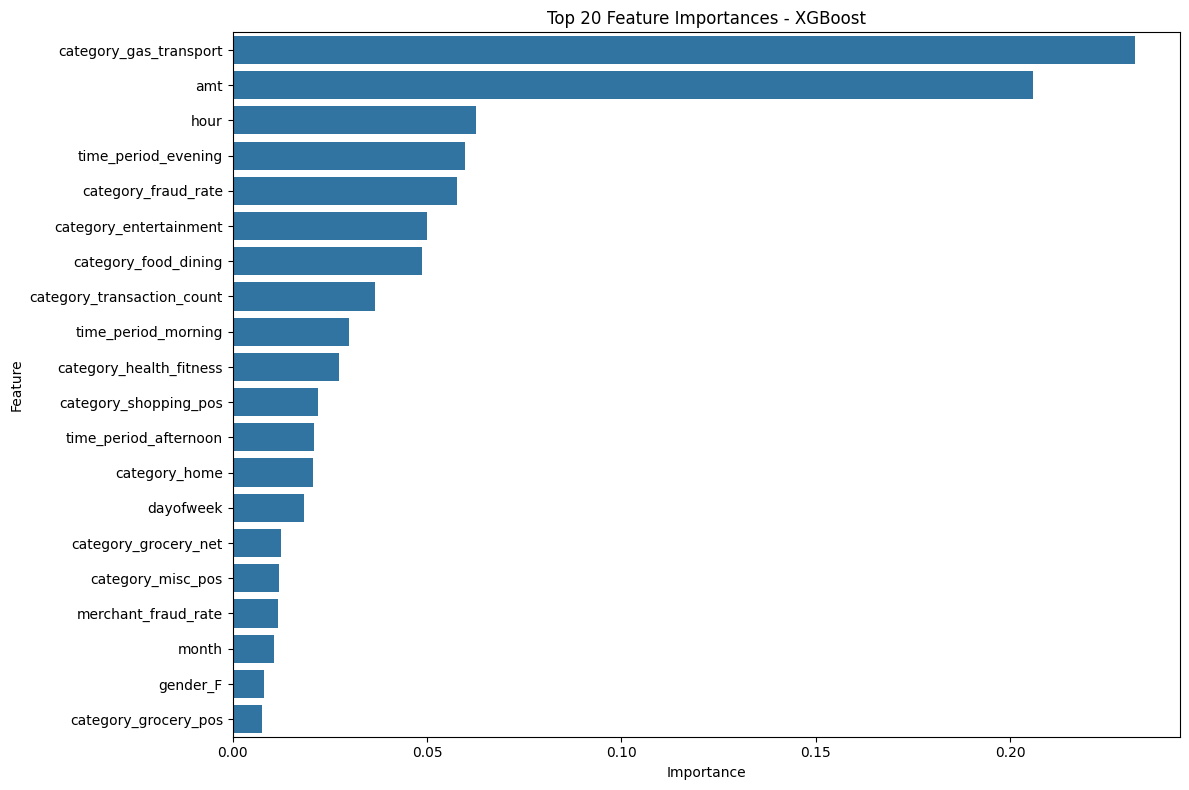


Top 20 important features:
                       Feature  Importance
22      category_gas_transport    0.232083
0                          amt    0.205804
3                         hour    0.062474
17         time_period_evening    0.059871
10         category_fraud_rate    0.057719
20      category_entertainment    0.049896
21        category_food_dining    0.048582
11  category_transaction_count    0.036631
18         time_period_morning    0.030012
25     category_health_fitness    0.027259
32       category_shopping_pos    0.021914
16       time_period_afternoon    0.021011
26               category_home    0.020698
6                    dayofweek    0.018233
23        category_grocery_net    0.012343
29           category_misc_pos    0.011793
8          merchant_fraud_rate    0.011761
5                        month    0.010688
14                    gender_F    0.007968
24        category_grocery_pos    0.007452


In [39]:
# Feature importance of the best model 
if hasattr(best_model[-1], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (
        numerical_features +
        best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    
    # Get feature importances
    importances = best_model[-1].feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 20 important features:")
    print(feature_importance_df.head(20))

## Analysis of Misclassification

In [40]:
# Analysis of misclassifications
if y_test is not None:
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Identify misclassified instances
    misclassified = test_df.copy()
    misclassified['predicted'] = y_pred
    misclassified['actual'] = y_test
    misclassified['is_misclassified'] = misclassified['predicted'] != misclassified['actual']
    
    # False positives
    false_positives = misclassified[(misclassified['predicted'] == 1) & (misclassified['actual'] == 0)]
    
    # False negatives
    false_negatives = misclassified[(misclassified['predicted'] == 0) & (misclassified['actual'] == 1)]
    
    print(f"\nNumber of false positives: {len(false_positives)}")
    print(f"Number of false negatives: {len(false_negatives)}")
    
    # Analyze characteristics of misclassifications
    print("\nFalse Positive Analysis:")
    for feature in numerical_features:
        fp_mean = false_positives[feature].mean()
        tn_mean = misclassified[(misclassified['predicted'] == 0) & (misclassified['actual'] == 0)][feature].mean()
        print(f"{feature}: FP mean = {fp_mean:.2f}, TN mean = {tn_mean:.2f}, Ratio = {fp_mean/tn_mean if tn_mean > 0 else 0:.2f}")
    
    print("\nFalse Negative Analysis:")
    for feature in numerical_features:
        fn_mean = false_negatives[feature].mean()
        tp_mean = misclassified[(misclassified['predicted'] == 1) & (misclassified['actual'] == 1)][feature].mean()
        print(f"{feature}: FN mean = {fn_mean:.2f}, TP mean = {tp_mean:.2f}, Ratio = {fn_mean/tp_mean if tp_mean > 0 else 0:.2f}")


Number of false positives: 595
Number of false negatives: 360

False Positive Analysis:
amt: FP mean = 364.48, TN mean = 67.29, Ratio = 5.42
distance_km: FP mean = 78.48, TN mean = 76.10, Ratio = 1.03
age: FP mean = 38.40, TN mean = 45.14, Ratio = 0.85
hour: FP mean = 18.60, TN mean = 12.80, Ratio = 1.45
day: FP mean = 16.23, TN mean = 16.47, Ratio = 0.99
month: FP mean = 9.14, TN mean = 9.51, Ratio = 0.96
dayofweek: FP mean = 2.80, TN mean = 2.73, Ratio = 1.03
city_pop: FP mean = 60478.56, TN mean = 88343.64, Ratio = 0.68
merchant_fraud_rate: FP mean = 0.01, TN mean = 0.01, Ratio = 1.10
merchant_transaction_count: FP mean = 1906.01, TN mean = 2045.33, Ratio = 0.93
category_fraud_rate: FP mean = 0.01, TN mean = 0.01, Ratio = 1.04
category_transaction_count: FP mean = 94771.63, TN mean = 100608.61, Ratio = 0.94
amount_ratio: FP mean = 5.65, TN mean = 0.96, Ratio = 5.86
transaction_recency: FP mean = 8815167.35, TN mean = 7850241.47, Ratio = 1.12

False Negative Analysis:
amt: FN mean =

## Threshold Tuning

In [48]:
# Threshold optimization for cost-sensitive detection
y_prob = best_model.predict_proba(X_test)[:, 1]

# Define cost matrix 
cost_fn = 100  # Cost of a false negative (missed fraud)
cost_fp = 10   # Cost of a false positive (false alarm)

# Calculate total cost for different thresholds
thresholds = np.linspace(0, 1, 100)
costs = []

for threshold in thresholds:
    y_pred_t = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    
    # Extract counts
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate total cost
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

# Find optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]

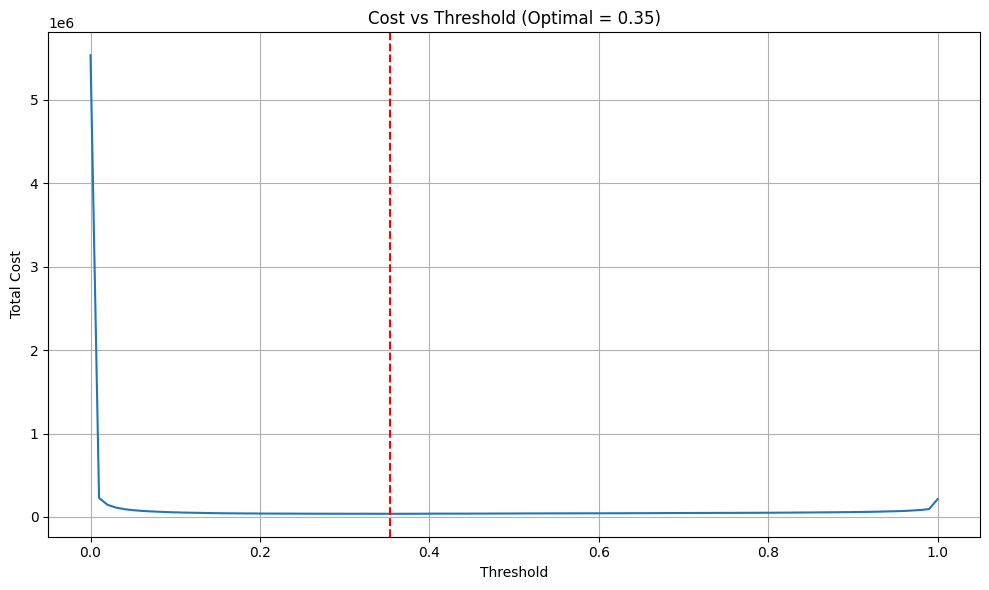


Optimal threshold for cost-sensitive detection: 0.35


In [49]:
# Plot cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs)
plt.axvline(x=optimal_threshold, color='r', linestyle='--')
plt.title(f'Cost vs Threshold (Optimal = {optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"\nOptimal threshold for cost-sensitive detection: {optimal_threshold:.2f}")


Performance with optimal threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.64      0.87      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.93      0.87    555719
weighted avg       1.00      1.00      1.00    555719



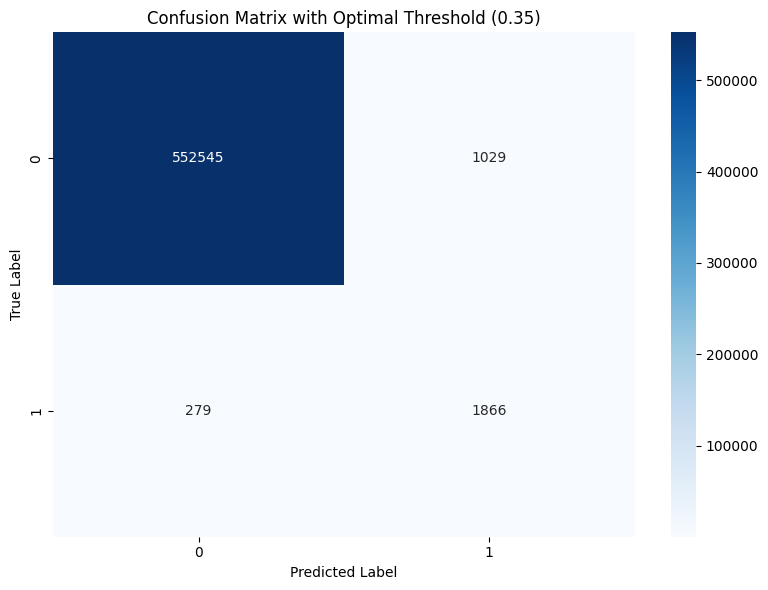

In [50]:
# Apply optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

print("\nPerformance with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

# Confusion Matrix with optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix with Optimal Threshold ({optimal_threshold:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Conclusion

In [42]:
# Conclusion
print("\nFraud Detection Model Summary:")
print(f"- Best model: {best_model_name}")
if y_test is not None:
    print(f"- ROC AUC on test set: {roc_auc:.4f}")
    print(f"- PR AUC on test set: {pr_auc:.4f}")
print("- Key features for fraud detection:")
if hasattr(best_model[-1], 'feature_importances_'):
    for feature, importance in feature_importance_df.head(5).values:
        print(f"  • {feature}: {importance:.4f}")


Fraud Detection Model Summary:
- Best model: XGBoost
- ROC AUC on test set: 0.9978
- PR AUC on test set: 0.9059
- Key features for fraud detection:
  • category_gas_transport: 0.2321
  • amt: 0.2058
  • hour: 0.0625
  • time_period_evening: 0.0599
  • category_fraud_rate: 0.0577
